# Outline of notebook and use of OSEMN framework:

### Obtain
The dataset provided for this study is a sample of residential houses from King County in the State of Washington, US.  Overall it is fairly easy and inuitive to understand the features, although some of the column descriptions provided are quite ambigous and need further investigation.

### Scrub
A number of columns contain null values, or placeholder values (such as '?'), so these need to be cleaned up before embarking on any significant EDA. In particular the waterfront column poses a problem because the number of null values amounts to almost 10% of the dataset, which is too many to delete.  The solution is found by using the lat/long data and plotting the homes with null waterfront values on a map in order to establish whether they are actually by the waterfront.

More granular exploration of the data is possible through the use of the King County online property viewer available here:

https://gismaps.kingcounty.gov/parcelviewer2/

The ID of each entry in the dataset can be used to view the details of specific properties.  For example:
https://blue.kingcounty.com/Assessor/eRealProperty/Detail.aspx?ParcelNbr=2402100895
- it is clear that the value of 33 bedrooms for this house was a data entry error.

This resource also clarifies that the column descriptions for view / sqft_living15 and sqft_lot15 are likely to be inaccurate and therefore the data can be disregarded. Email communication with the King County Deparment of Assessments has also been used to clarify the meaning of some aspects of the data.  (For example the float values for the bathrooms column is a result of a bathroom without a bathtub being given a value of 0.75, and a bathroom with just a toilet and sink 0.5).

### Explore
Exploration of the data is primarily acheived through side-by-side observations of scatterplots and histograms. It quickly becomes apparent that some features are not relevant to the target variable (price), while others will need to be incorporated as categorical rather than continuous variables.  Multi-collinearity is a major issue in the dataset, with almost all features that show a relationship to price being also correlated to eachother.  The work-around here is to use grade as a categorical feature and to incorporate zipcodes as a predictor using mean house prices for each zipcode.

### Model
Two models are created before ending up with the final model used for house-price prediciton.

Model 1 is simply a base-line model including nearly all the features available and the entire dataset.  

Model 2 removes all continuous variables that are highly correlated with eachother, as well as columns regarded as irrelevant. In addition the dataset is trimmed to remove non-typical houses based on a number of factors.  The model also includes categorical variables based on a number of features such as zipcode and grade.  

The final model is created after running feature selection on Model 2 to establish the most significant features - in conjunction with an inuitive sense of what will make most sense when applying the model to real-world scenarios.  The performance of the final model is measured using k-fold cross validation and comparison of MSE values.

Please see markdown below the final model for more detail.

### Interpretation
The regression model shows quite clearly that zipcode and grade are highly influential factors on the price of a home, alongiside square-footage of the total living area.  The model is in fact best understood and interpreted alongside other insights into the dataset - most notably the use of maps to plot where the zipcodes are located, and also the visualisation of house features using grade as the target variable.  Since it is clear that a higher grade increases house price,  it is then of course useful to see which factors have the strongest influence on grade - and to aim to find recommendations for homeowners based on those findings.

### Four meaningful questions answered during EDA:

### <span style="color:blue"> Are waterfront homes relevant to the analysis? </span>

### <span style="color:blue"> Do any of the continuous variable features display collinearity and if so which ones should be excluded from regression? </span>

### <span style=color:blue>Which features are suitable for trimming the dataset to ensure it represents a broad but reasonably typical range of homes?</span>

### <span style=color:blue>Are there any duplicate entries in the analysis and if so how should they be dealt with?</span>

Note: some cells in the notebook have been set to not run with the # comment symbol.  This can removed to see the cell output that might clarify a particular step.

# Import libraries required for EDA, visualisation and regression:

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import statsmodels.formula.api as smf

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Import dataset and cross-check against feature descriptions provided - assess features for relevance based on descriptions:

In [11]:
df = pd.read_csv('kc_house_data.csv')

In [12]:
#short-hand for getting a count of a dataset (cod)
def cod(df):
    print('This dataset contains ' + str(df.shape[0]) + ' entries and ' + str(df.shape[1]) + ' columns')

cod(df)

This dataset contains 21597 entries and 21 columns


In [13]:
df.price.max()

7700000.0

# CLEAN DATASET

All columns are of the expected format except sqft_basement which should be a number.

The NaN values for waterfront, view and yr_renovated need to be dealt with.

In [14]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


(None, id                  0
 date                0
 price               0
 bedrooms            0
 bathrooms           0
 sqft_living         0
 sqft_lot            0
 floors              0
 waterfront       2376
 view               63
 condition           0
 grade               0
 sqft_above          0
 sqft_basement       0
 yr_built            0
 yr_renovated     3842
 zipcode             0
 lat                 0
 long                0
 sqft_living15       0
 sqft_lot15          0
 dtype: int64)

In [15]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


# Clean sqft_basement column:

In [16]:
#df.sqft_basement.unique()

There are 454 entries where sqft_basement is set to '?'.  However, sqft_basement can be calculated by subtracting sqft_above from sqft_living, so a new column can be created where the '?' values are replaced with correct figures:

In [17]:
df['basement_size'] = df['sqft_living'] - df['sqft_above']

In [18]:
#df[df['sqft_basement']=='?'].head(10)

In [19]:
df.sort_values('basement_size').tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement_size
10074,7767000060,9/12/2014,1900000.0,5,4.25,6510,16471,2.0,0.0,3.0,...,3250,3260.0,1980,0.0,98040,47.5758,-122.242,4480,16471,3260
7245,6762700020,10/13/2014,7700000.0,6,8.00,12050,27600,2.5,0.0,3.0,...,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800,3480
15468,624069108,8/12/2014,3200000.0,4,3.25,7000,28206,1.0,1.0,4.0,...,3500,3500.0,1991,0.0,98075,47.5928,-122.086,4913,14663,3500
12764,1225069038,5/5/2014,2280000.0,7,8.00,13540,307752,3.0,0.0,4.0,...,9410,4130.0,1999,0.0,98053,47.6675,-121.986,4850,217800,4130
8085,1924059029,6/17/2014,4670000.0,5,6.75,9640,13068,1.0,1.0,4.0,...,4820,4820.0,1983,2009.0,98040,47.5570,-122.210,3270,10454,4820


basement_size also has the advantage of being a number formatted column.  The original sqft_basement column can be dropped.

In [20]:
df.drop('sqft_basement', axis = 1, inplace = True)

# Delete view column 

The meaning of this column is too ambiguous - it is described as 'has been viewed' but properties on the KC assessor site show views as relating to the panoramas visible from the home.

https://blue.kingcounty.com/Assessor/eRealProperty/Detail.aspx?ParcelNbr=0624069108

Plus there are only a small number of values.  For these reasons it can be deleted.

In [21]:
df.drop('view', axis =1, inplace = True)

# Delete yr_renovated column:

In [22]:
print('The yr_renovated column has ' + str(df.yr_renovated.isna().sum()) + ' NaN values')
print('The yr_renovated column has ' + str(len(df[df.yr_renovated == 0])) + ' values set to 0')
print('The yr_renovated column has ' + str(len(df[df.yr_renovated > 0])) + ' actual date values')

The yr_renovated column has 3842 NaN values
The yr_renovated column has 17011 values set to 0
The yr_renovated column has 744 actual date values


There are only 739 actual values for yr_renovated in the dataset, so this column can be excluded from the analysis.

In [23]:
df.drop('yr_renovated', axis =1, inplace=True)

# <span style="color:blue"> Are waterfront homes relevant to the analysis? </span>

In [24]:
print('There are ' + str(df.waterfront.isna().sum()) + ' NaN values in the Waterfront column')

There are 2376 NaN values in the Waterfront column


The locations of houses with waterfront NAN values can be plotted on a map, using lat and long data

This reveals that all the houses with NaN values are (with an extremely small minority) not near the waterfront.  Note: waterfront homes are literally on the edge of the waterfront - being close by does not qualify (see maps).

So the NaN values can be set to 0 (not waterfront).<br>

<img src="waterfront NANs both.png">

<img src="WF homes close1.png" width= 40%, height= 40%>

In [25]:
df['waterfront'].fillna(0, inplace=True)

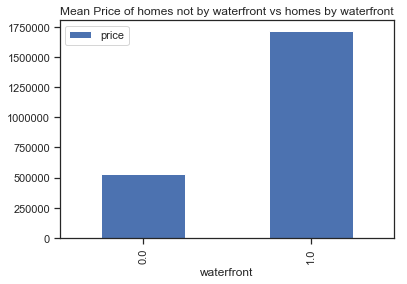

In [26]:
df.groupby('waterfront').mean()[['price']].round().plot.bar(title='Mean Price of homes not by waterfront vs homes by waterfront');

In [27]:
df.waterfront.value_counts()

0.0    21451
1.0      146
Name: waterfront, dtype: int64

There are only 142 waterfront properties but their mean price is over 3 times higher than non-waterfront properties.  

So it will make sense to drop the 142 waterfront properties from the dataset, and then drop the column, as they are not at all representative of the majoritity of the dataset.

In [28]:
drop_wf_houses = df[df['waterfront']==1]
df.drop(drop_wf_houses.index, axis = 0, inplace=True)

In [29]:
df.drop('waterfront', axis =1, inplace=True)

In [30]:
df.reset_index(inplace=True, drop=True)

In [31]:
cod(df)
df.tail()

This dataset contains 21451 entries and 18 columns


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,basement_size
21446,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,3,8,1530,2009,98103,47.6993,-122.346,1530,1509,0
21447,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,3,8,2310,2014,98146,47.5107,-122.362,1830,7200,0
21448,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,3,7,1020,2009,98144,47.5944,-122.299,1020,2007,0
21449,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,3,8,1600,2004,98027,47.5345,-122.069,1410,1287,0
21450,1523300157,10/15/2014,325000.0,2,0.75,1020,1076,2.0,3,7,1020,2008,98144,47.5941,-122.299,1020,1357,0


# SQFT_LIVING15 & SQFT_LOT15

There is significant ambiguity over the meaning of the sqft_living15 and sqft_lot15 features.  They appear to be on completely different scales as their maximum values do not correspond at all to the figures for sqft_living and sqft_lot.

In [32]:
df[['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']].describe()

,sqft_living,sqft_living15,sqft_lot,sqft_lot15
count,21451.000000,21451.000000,2.145100e+04,21451.000000
mean,2072.396485,1981.881777,1.502610e+04,12689.299753
std,906.042446,681.907132,4.138140e+04,27287.285949
min,370.000000,399.000000,5.200000e+02,651.000000
25%,1420.000000,1480.000000,5.035000e+03,5100.000000
50%,1910.000000,1830.000000,7.590000e+03,7601.000000
75%,2540.000000,2356.000000,1.057850e+04,10025.500000
max,13540.000000,6210.000000,1.651359e+06,871200.000000


Detail on specific instances of properties can be investigated below:

In [33]:
df[(df['sqft_living']>10000) | (df['sqft_lot']>1150000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,basement_size
1698,1020069017,3/27/2015,700000.0,4,1.0,1300,1651359,1.0,4,6,1300,1920,98022,47.2313,-122.023,2560,425581,0
7192,6762700020,10/13/2014,7700000.0,6,8.0,12050,27600,2.5,4,13,8570,1910,98102,47.6298,-122.323,3940,8800,3480
12678,1225069038,5/5/2014,2280000.0,7,8.0,13540,307752,3.0,3,12,9410,1999,98053,47.6675,-121.986,4850,217800,4130
17186,3326079016,5/4/2015,190000.0,2,1.0,710,1164794,1.0,2,5,710,1915,98014,47.6888,-121.909,1680,16730,0


https://blue.kingcounty.com/Assessor/eRealProperty/Dashboard.aspx?ParcelNbr=1225069038

Clearly the lot size of this property did not decrease by almost 100,000 sqft, and living by almost 10,000 due to renovations.  It is more likely that the sqft_living15 and sqft_lot15 figures correspond so some other metric, and the description provided is wrong.  

Furthermore correspondance with the KCGIS centre revealed they also had no record of those features in their database. 

For these reasons they can both be ignored and deleted.

In [34]:
df.drop('sqft_living15', axis =1, inplace=True)
df.drop('sqft_lot15', axis =1, inplace=True)

# GET A SENSE OF THE DATA USING SCATTER PLOTS & HISTOGRAMS

The features of interest are one which are - at least in theory - subject to change by the homeowner.

Other features can be used to create categories (e.g zipcode & yr_built)

In [35]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'yr_built',
       'zipcode', 'lat', 'long', 'basement_size'],
      dtype='object')

In [36]:
df_view = df.drop(['id', 'date', 'zipcode', 'lat', 'long'], axis=1)

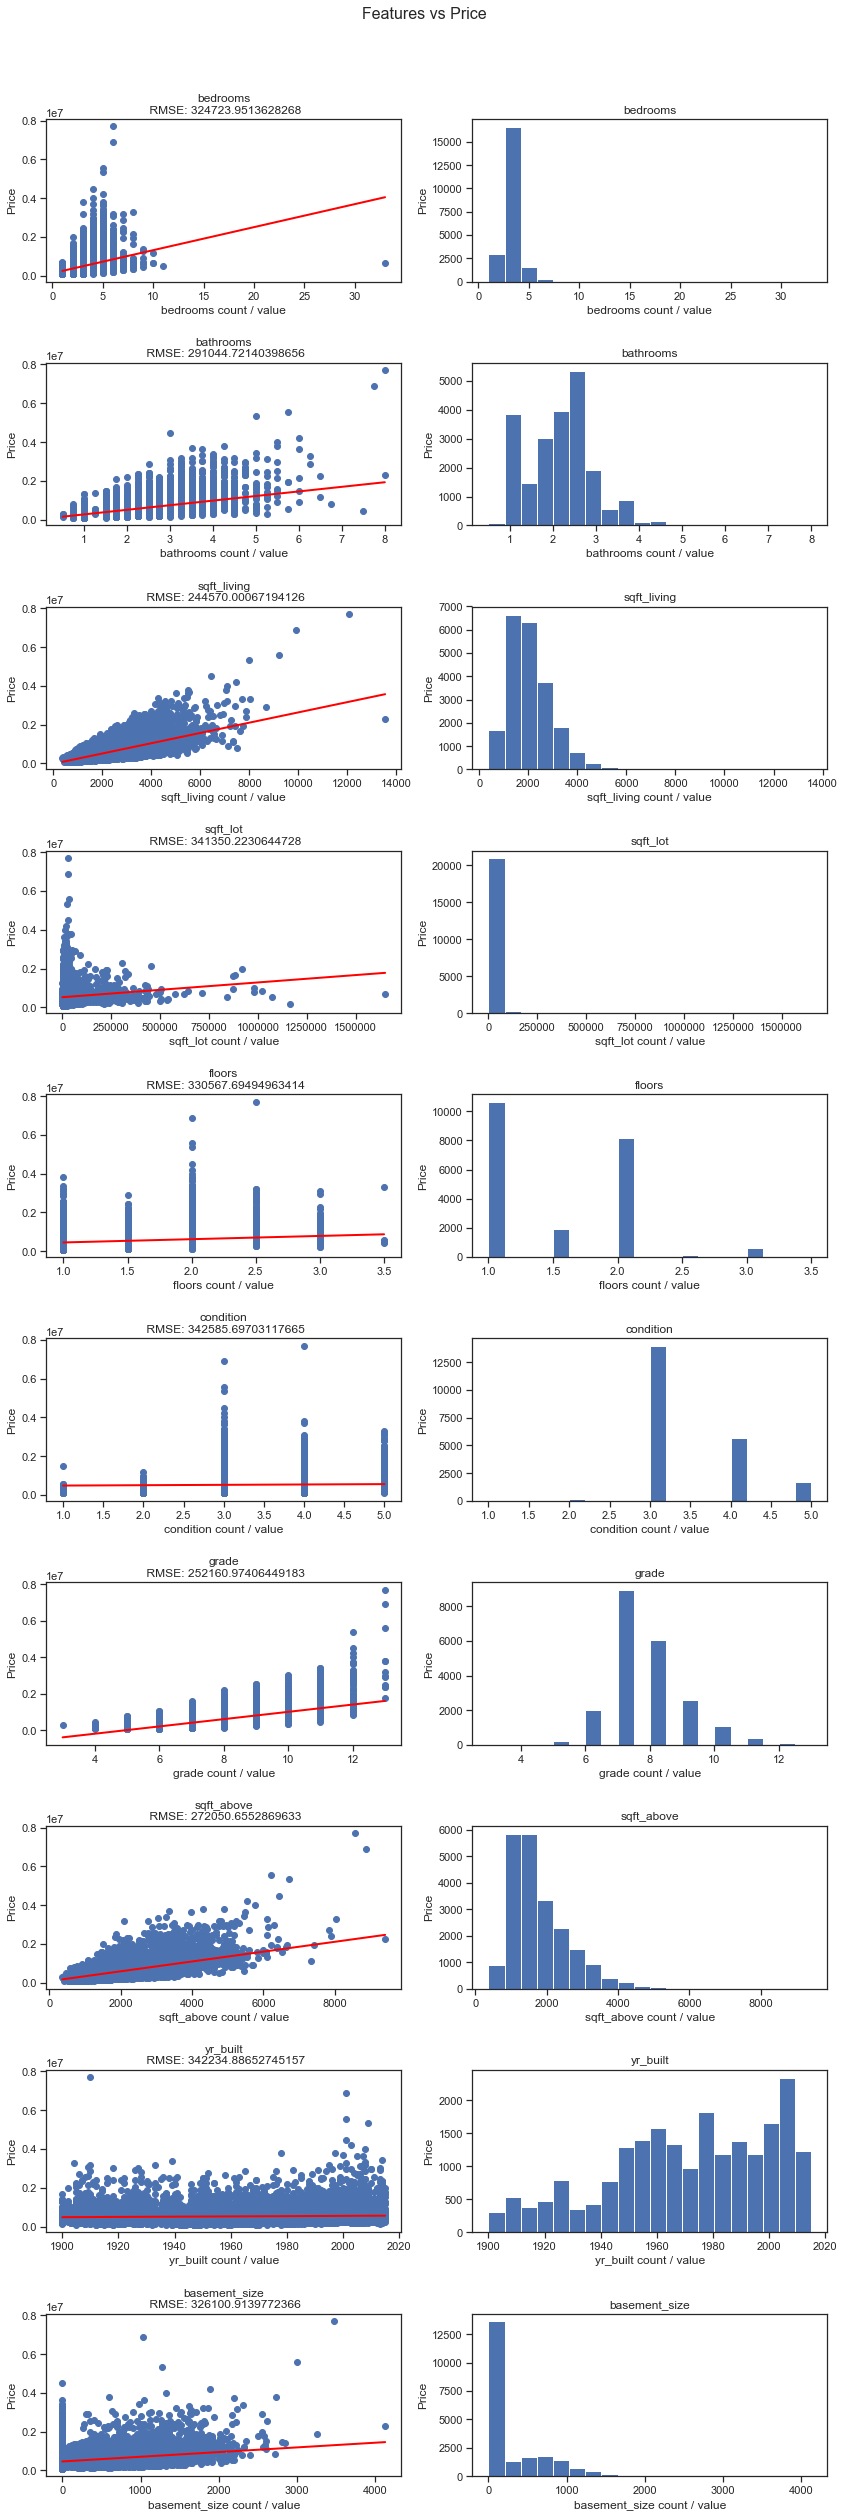

In [37]:
#%%capture
fig = plt.figure(figsize = (14,52))
fig.suptitle('Features vs Price', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plot_pos = 1

for i in df_view.columns:
    if i != 'price':
        ax = plt.subplot(13,2,plot_pos)
        ax.scatter(df_view[[i]], df_view.price)
        ax.set_xlabel(str(i) + ' count / value')
        ax.set_ylabel('Price')
        lm = smf.ols(formula = 'price ~ ' + str(i), data = df_view).fit()
        X_new = pd.DataFrame({str(i): [df_view[i].min(), df_view[i].max()]})
        preds = lm.predict(X_new)
        ax.plot(X_new, preds, c='red', linewidth=2)
        rmse = np.sqrt(np.mean(np.array(list(lm.resid))**2))
        ax.set_title(str(i) + '\n RMSE: ' + str(rmse))
        #ax.set_title('Corr: ' + str(df_view[['price',i]].corr().iloc[0:1,1:]))
        plt.subplots_adjust(hspace=0.5)
        plot_pos += 1
        ax = plt.subplot(13,2,plot_pos)
        ax.hist(df_view[i], bins=20)
        ax.set_title(str(i))
        ax.set_xlabel(str(i) + ' count / value')
        ax.set_ylabel('Price')
        plt.subplots_adjust(hspace=0.5)
        plot_pos += 1
        
#fig.savefig('Features vs Price')

## Features that show no correlation with price can be ignored:

condition

sqft_lot

yr_built

# Model 1:

In [38]:
model_1 = df.drop(['id', 'date', 'zipcode', 'lat', 'long', 'condition' ,'sqft_lot', 'yr_built'], axis=1)

In [39]:
y_1 = model_1[['price']]
X_1 = model_1.drop(['price'], axis = 1)
#y = kcd_final[['price']]
#X = kcd_final.drop(['price'], axis = 1)

In [40]:
model_no = 'Model 1'

X = X_1
y = y_1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)

linreg.fit(X_train,y_train)
yhat_train = linreg.predict(X_train)
yhat_test = linreg.predict(X_test)
mse_train = np.sum((y_train-yhat_train)**2)/len(y_train)
rmse_train = np.sqrt(mse_train)
mse_test =np.sum((y_test-yhat_test)**2)/len(y_test)
rmse_test = np.sqrt(mse_test)
y_int = sm.add_constant(X)
model = sm.OLS(y,y_int).fit()

print('-------\n' + model_no + '\n-------')
print('The train mse is ' + str(list(mse_train)[0]))
print('The test mse is  ' + str(list(mse_test)[0]))
print('\nThe train rmse is ' + str(list(rmse_train)[0]))
print('The test rmse is ' + str(list(rmse_test)[0]))

#list((mse_train/mse_test)*100)[0]

print('\nThe R-Squared is ' + str(model.rsquared))
model.summary()

-------
Model 1
-------
The train mse is 52837211104.93444
The test mse is  51112869958.20258

The train rmse is 229863.46187451028
The test rmse is 226081.55598854716

The R-Squared is 0.5533622095055976


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     4428.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        08:03:07   Log-Likelihood:            -2.9518e+05
No. Observations:               21451   AIC:                         5.904e+05
Df Residuals:                   21444   BIC:                         5.904e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.334e+05   1.42e+04    -37.516      0.000   -5.61e+05   -5.06e+05
bedrooms      -3.222e+04   2148.117    -14.999      0.000   -3.64e+04    -2.8e+04
bathrooms      -2.12e+04   3495.213     -6.064      0.000    -2.8e+04   -1.43e+04
sqft_living     140.9142      2.358     59.750      0.000     136.292     145.537
floors        -9160.4865   3882.047     -2.360      0.018   -1.68e+04   -1551.384
grade          1.104e+05   2261.887     48.802      0.000    1.06e+05    1.15e+05
sqft_above       37.2646      2.282     16.327      0.000      32.791      41.738
basement_size   103.6496      2.851     36.350      0.000      98.061     109.239
==============================================================================
Omnibus:                    15576.877   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           856030.120
Skew:                           2.937   Prob(JB):                         0.00
Kurtosis:                      33.385   Cond. No.                     6.21e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.99e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Comments:

This is a first pass that includes too many features, many of which are likely to be correlated together and some of which would be more appropriately used as categorical variables.  The R-Squared is low at just over 0.5.


## Features to be changed to categorical variables:

Floors

Basement - yes / no

Grade

Zipcode (not shown above.  Zipcode bins can be created based on mean house price per zipcode).

# <span style="color:blue"> Do any of the continuous variable features display collinearity and if so which ones should be excluded from regression? </span>

In [41]:
df_view_corr = df.drop(['id', 'date', 'zipcode', 'lat', 'long', 'sqft_lot', 'yr_built', 'basement_size', 'floors', 'condition'], axis=1)
df_view_corr.corr()

,price,bedrooms,bathrooms,sqft_living,grade,sqft_above
price,1.000000,0.320440,0.528358,0.700709,0.677425,0.608423
bedrooms,0.320440,1.000000,0.514691,0.582756,0.357643,0.480499
bathrooms,0.528358,0.514691,1.000000,0.754554,0.663866,0.684477
sqft_living,0.700709,0.582756,0.754554,1.000000,0.760906,0.876120
grade,0.677425,0.357643,0.663866,0.760906,1.000000,0.754865
sqft_above,0.608423,0.480499,0.684477,0.876120,0.754865,1.000000


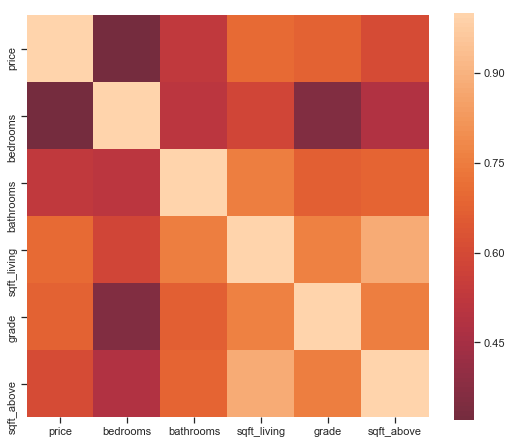

In [42]:
fig = plt.figure(figsize = (9,7.5))
ax = plt.subplot(1,1,1)
sns.heatmap(df_view_corr.corr(), center=0, ax=ax, square=True);

Sqft_living is the feature most highly correlated with price.  It displays strong collinearity with bathrooms, sqft_above and grade, and some collinearity with bedrooms.

To avoid multi-collinearity during regression, bathrooms and sqft_above will be excluded and grade will be used to create categorical variables.

# <span style=color:blue>Which features are suitable for trimming the dataset to ensure it represents a broad but reasonably typical range of homes?</span>

### Grade, Condition and sqft_lot show clear distributions of the dataset into specific ranges.  Those containing very small numbers of houses can be removed.

Note: Sqft_lot is not correlated with price and will not be used in regression, it is just being used to trim the dataset and exclude properties outside of the main range of the dataset.

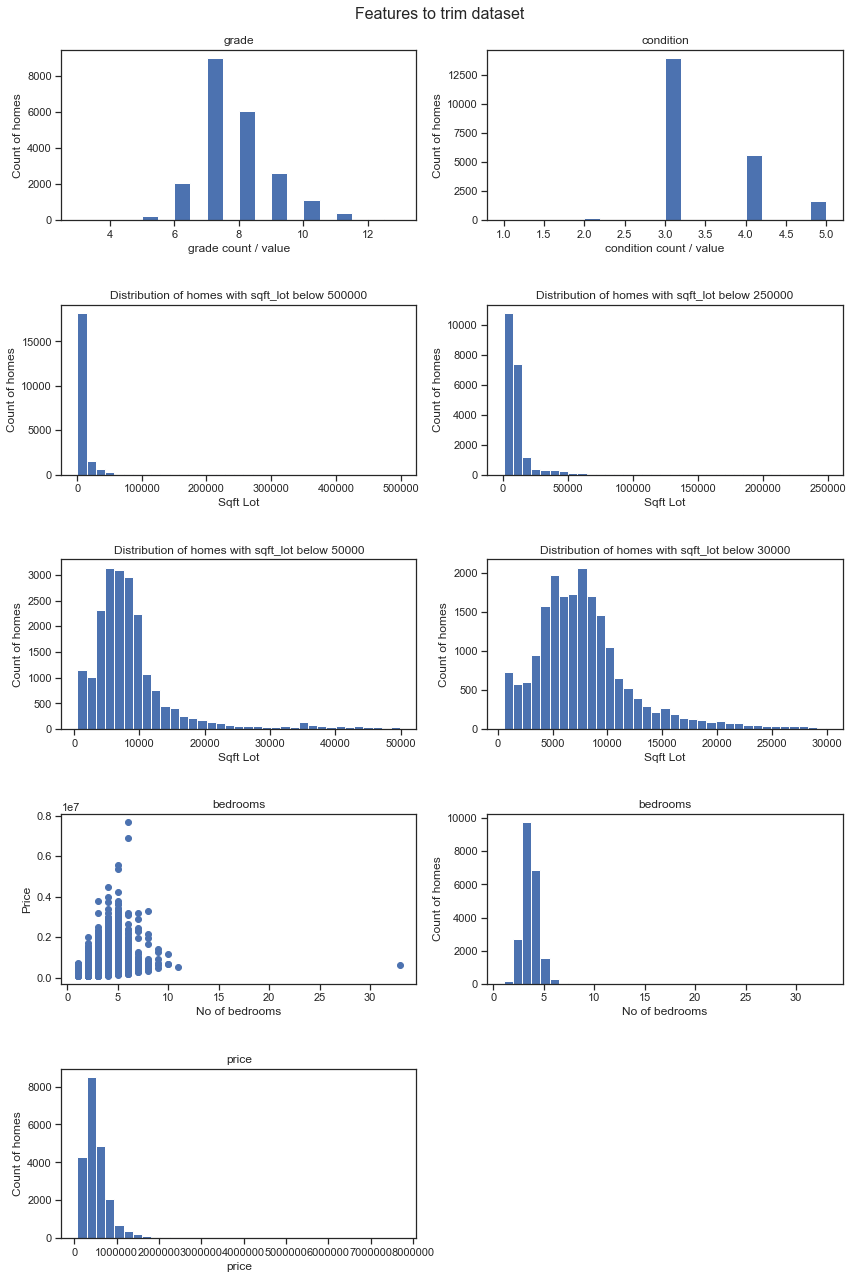

In [43]:
fig = plt.figure(figsize = (14,20))
fig.suptitle('Features to trim dataset', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plot_pos = 1

for i in ['grade', 'condition']:
    ax = plt.subplot(5,2,plot_pos)
    ax.hist(df_view[i], bins=20)
    ax.set_title(str(i))
    ax.set_xlabel(str(i) + ' count / value')
    ax.set_ylabel('Count of homes')
    plt.subplots_adjust(hspace=0.5)
    plot_pos += 1
    
for i in [500000,250000,50000,30000]:
    trim = df[df['sqft_lot']<i]
    ax = plt.subplot(5,2,plot_pos)
    ax.hist(trim['sqft_lot'], bins = 35)
    ax.set_title('Distribution of homes with sqft_lot below ' + str(i))
    ax.set_xlabel('Sqft Lot')
    ax.set_ylabel('Count of homes')
    plot_pos += 1
    
ax = plt.subplot(5,2,plot_pos)    
ax.scatter(df_view[['bedrooms']], df_view.price)
ax.set_title('bedrooms')
ax.set_xlabel('No of bedrooms')
ax.set_ylabel('Price')
plot_pos += 1

ax = plt.subplot(5,2,plot_pos) 
ax.hist(df_view['bedrooms'], bins=35)
ax.set_title('bedrooms')
ax.set_xlabel('No of bedrooms')
ax.set_ylabel('Count of homes');
plot_pos += 1

ax = plt.subplot(5,2,plot_pos) 
ax.hist(df_view['price'], bins=35)
ax.set_title('price')
ax.set_xlabel('price')
ax.set_ylabel('Count of homes');


### The following parameters can be used to trim the dataset:
    
Bedrooms below 8 (remove obvious outlier)<br>
Grade between 6 and 11<br>
Condition 3 or above<br>
sqft_lot below 20000<br>
price below $2m

In [44]:
df_trim = df[(df['grade']>5) & (df['grade']<12) & (df['condition']>2) & (df['sqft_lot']<20000) & (df['bedrooms']<8) & (df['price']<2000000)].copy()

In [45]:
print(df_trim.grade.value_counts().sort_index())
print(df_trim.condition.value_counts())
cod(df_trim)

6     1833
7     8348
8     5416
9     2122
10     770
11     196
Name: grade, dtype: int64
3    12323
4     4855
5     1507
Name: condition, dtype: int64
This dataset contains 18685 entries and 16 columns


## <span style=color:blue>Are there any duplicate entries in the analysis and if so how should they be dealt with?</span>

Each property has a unique ID number in the ID column, and each property should appear only once in the dataset:

In [46]:
#find entries with duplicate IDs
id_list = {}
for i in df_trim.id:
    if id_list.get(i)==None:
        id_list[i] = 1
    else:
        id_list[i] += 1

double_ids = []
for key, value in id_list.items():
    if value > 1:
        double_ids.append(key)
        
print('There are ' + str(len(double_ids)) + ' houses with the same ID')

There are 152 houses with the same ID


In [47]:
frames = []
for id_val in double_ids:
    frames.append(df_trim[df_trim.id == id_val])
duplicate_entries = pd.concat(frames)

In [48]:
duplicate_entries.head(6)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement_size
92,6021501535,7/25/2014,430000.0,3,1.50,1580,5000,1.0,3,8,1290,1939,98117,47.6870,-122.386,290
93,6021501535,12/23/2014,700000.0,3,1.50,1580,5000,1.0,3,8,1290,1939,98117,47.6870,-122.386,290
308,4139480200,6/18/2014,1380000.0,4,3.25,4290,12103,1.0,3,11,2690,1997,98006,47.5503,-122.102,1600
309,4139480200,12/9/2014,1400000.0,4,3.25,4290,12103,1.0,3,11,2690,1997,98006,47.5503,-122.102,1600
319,7520000520,9/5/2014,232000.0,2,1.00,1240,12092,1.0,3,6,960,1922,98146,47.4957,-122.352,280
320,7520000520,3/11/2015,240500.0,2,1.00,1240,12092,1.0,3,6,960,1922,98146,47.4957,-122.352,280


Conclusion - these duplicate entries appear to show that house prices are subject to significant variation depending soley on the sale date, irrespective of other factors.  

Correspondance with the KCGIS revealed that refurbishment had a significant impact on sale price.  For example property ID 6021501535:

The listing from July 2014:

https://www.redfin.com/WA/Seattle/8001-23rd-Ave-NW-98117/home/165496/nwmls-596311

The listing from December 2014:

https://www.redfin.com/WA/Seattle/8001-23rd-Ave-NW-98117/home/165496/nwmls-713942

However, it is worth noting that condition rating for this column remained unchanged on the second sale date when the price rose by $27,000.  This calls into question the reliability of the condition feature.

These issues can be invesigated separately but in order to analyse the influence of the other features on price, all houses with duplicate entries will be deleted.  

Condition can also be disregarded in the analysis going forward.

In [49]:
id_index = pd.DataFrame(df_trim['id'])
id_index.set_index('id', inplace=True)

drop_duplicates = id_index.loc[double_ids]

In [50]:
df_trim.set_index('id', inplace=True)

In [51]:
df_trim.drop(drop_duplicates.index, axis = 0, inplace=True)

In [52]:
df_trim.reset_index(inplace=True)

## Remove geographical outliers - it is likely that houses a long way from the bay area are influenced by different price factors:

<img src="King County Housing trim zips_del.png" width= 40%, height= 40%>

In [53]:
df_trim_out_of_town = df_trim.drop(df_trim[(df_trim.zipcode == 98022) | (df_trim.zipcode == 98045)].index)
len(df_trim) - len(df_trim_out_of_town)

282

In [54]:
df_trim = df_trim_out_of_town

In [55]:
df_trim.reset_index(inplace=True, drop=True)

In [56]:
len(df_trim.zipcode.unique())

68

In [57]:
cod(df_trim)
df_trim.tail()

This dataset contains 18099 entries and 16 columns


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement_size
18094,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,3,8,1530,2009,98103,47.6993,-122.346,0
18095,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,3,8,2310,2014,98146,47.5107,-122.362,0
18096,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,3,7,1020,2009,98144,47.5944,-122.299,0
18097,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,3,8,1600,2004,98027,47.5345,-122.069,0
18098,1523300157,10/15/2014,325000.0,2,0.75,1020,1076,2.0,3,7,1020,2008,98144,47.5941,-122.299,0


What % of the original dataset is left?

In [58]:
(len(df_trim)/len(df)) * 100

84.37368887231365

# Review the data again based on trimmed data:

In [59]:
df_view_new = df_trim.drop(['id', 'date', 'zipcode', 'yr_built', 'lat', 'long', 'condition', 'floors', 'basement_size', 'grade', 'sqft_above', 'sqft_lot'], axis=1)

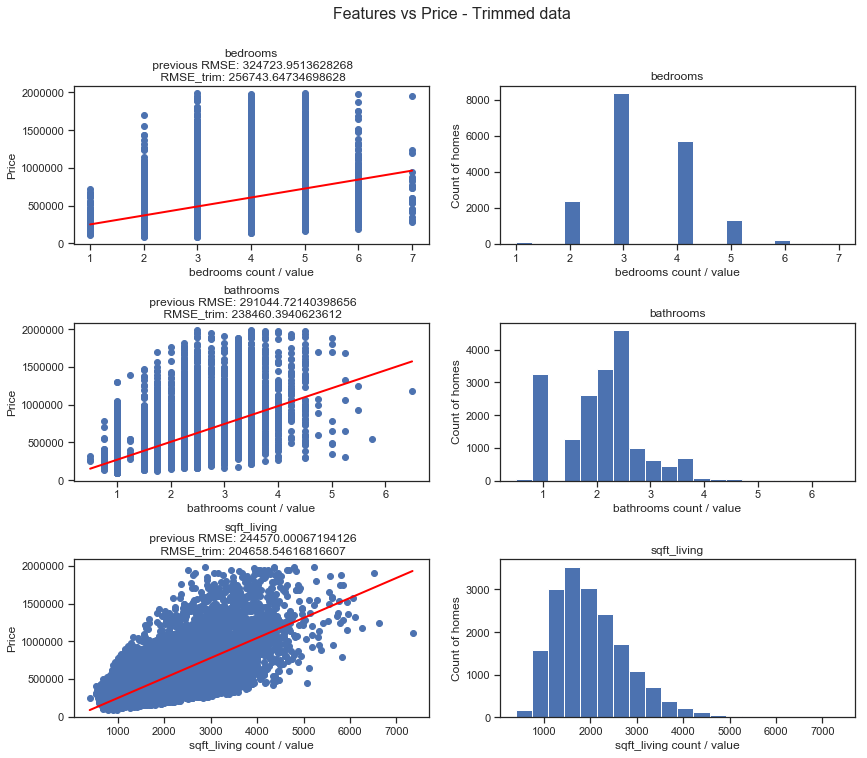

In [60]:
#%%capture
fig = plt.figure(figsize = (14,50))
fig.suptitle('Features vs Price - Trimmed data', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.958)

plot_pos = 1

for i in df_view_new.columns:
    if i != 'price':
        ax = plt.subplot(13,2,plot_pos)
        ax.scatter(df_trim[[i]], df_trim.price)
        ax.set_xlabel(str(i) + ' count / value')
        ax.set_ylabel('Price')
        lm = smf.ols(formula = 'price ~ ' + str(i), data = df).fit()
        lm_trim = smf.ols(formula = 'price ~ ' + str(i), data = df_trim).fit()
        X_new = pd.DataFrame({str(i): [df_trim[i].min(), df_trim[i].max()]})
        preds = lm.predict(X_new)
        ax.plot(X_new, preds, c='red', linewidth=2)
        rmse = np.sqrt(np.mean(np.array(list(lm.resid))**2))
        rmse_trim = np.sqrt(np.mean(np.array(list(lm_trim.resid))**2))
        ax.set_title(str(i) + '\n previous RMSE: ' + str(rmse) + '\n RMSE_trim: ' + str(rmse_trim))
        #ax.set_title('Corr: ' + str(df_trim[['price',i]].corr().iloc[0:1,1:]))
        plt.subplots_adjust(hspace=0.5)
        plot_pos += 1
        ax = plt.subplot(13,2,plot_pos)
        ax.hist(df_trim[i], bins=20)
        ax.set_title(str(i))
        ax.set_xlabel(str(i) + ' count / value')
        ax.set_ylabel('Count of homes')
        plt.subplots_adjust(hspace=0.5)
        plot_pos += 1
        
#fig.savefig('Features vs Price')

# Create categorical variables for Zipcode, grade, basement and floors

Visualise zipcodes by mean price:

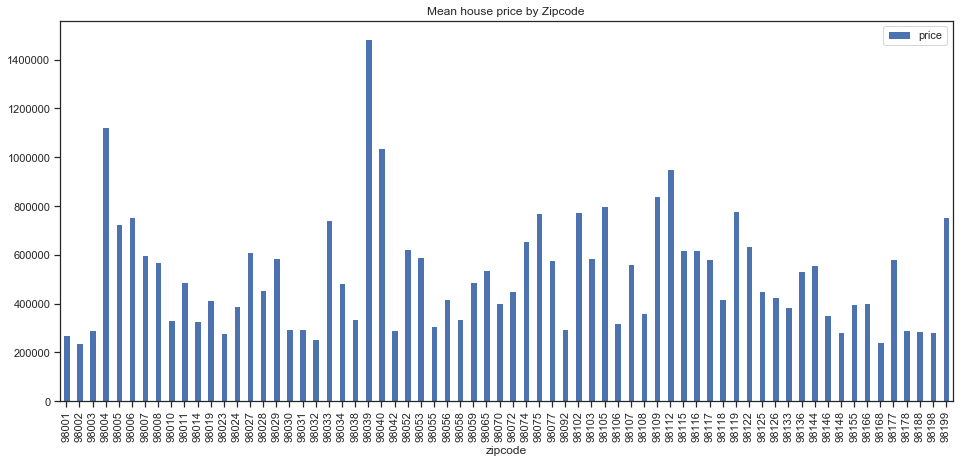

In [61]:
df_trim.groupby('zipcode').mean()[['price']].round().plot.bar(figsize=(16,7), title='Mean house price by Zipcode');

In [62]:
#create dataframe of mean houses prices by zipcode
zip_mean_price = df_trim.groupby('zipcode').mean()
zip_mean_price.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,lat,long,basement_size
zipcode,,,,,,,,,,,,,,
98001,4.691185e+09,2.732948e+05,3.459184,2.076531,1900.306122,9131.068027,1.459184,3.285714,7.316327,1733.367347,1985.129252,47.311252,-122.270544,166.938776
98002,4.838877e+09,2.390717e+05,3.381215,1.878453,1667.077348,7441.519337,1.353591,3.729282,6.806630,1563.618785,1970.436464,47.309501,-122.213597,103.458564
98003,4.756655e+09,2.901519e+05,3.351351,2.035714,1900.011583,9316.061776,1.312741,3.378378,7.521236,1641.675676,1977.378378,47.315982,-122.310089,258.335907
98004,4.199169e+09,1.122314e+06,3.654008,2.331224,2522.827004,10740.299578,1.413502,3.540084,8.299578,2139.409283,1969.400844,47.613465,-122.203333,383.417722
98005,5.837109e+09,7.275780e+05,3.719008,2.256198,2347.685950,11170.479339,1.177686,3.801653,8.082645,1882.809917,1967.471074,47.602703,-122.169124,464.876033


remove the higher outlier zipcodes (where mean price is over $1m):

In [63]:
zip_mean_price_olo = zip_mean_price[zip_mean_price['price']<1000000]

create a list of mean prices of zipcodes, not including the outliers

In [64]:
mean_prices_olo = list(zip_mean_price_olo['price'])

create a look-up table that includes each zipcode only once:

In [65]:
findzipcode = df_trim.groupby('zipcode').mean()[['price']]
findzipcode.reset_index(inplace = True)

In [66]:
#function that takes in a list of zipcodes and df, and returns the total number of homes in all zipcodes from list

def count_of_homes(zips_in_bin, df):
    #print(zips_in_bin.sort_values('price'))
    count_of_homes = 0
    for i in zips_in_bin.zipcode:
        for zipcode in df.zipcode:
            if i == zipcode:
                count_of_homes += 1
        output = count_of_homes
    return output

In [67]:
%%capture

#function creates histogram with n number of zipcode bins

def zipcodebins(list_of_mean_zip_prices, n):
    fig = plt.figure(figsize = (15,7))
    axes = plt.subplot(1,1,1)
    axes.set_title('Distribution of zipcodes by mean house price')
    axes.set_xlabel('Mean house price')
    axes.set_ylabel('Count of zipcodes')
    zipcode_count, bins, null2 = axes.hist(list_of_mean_zip_prices, bins=n)
    bin_no = 1
    total_no_zipcodes = 0
    total_no_houses = 0
    frames = []
    for i in zipcode_count:
        zips_in_bin = findzipcode[(findzipcode['price']>=bins[bin_no-1]) & (findzipcode['price']<=bins[bin_no])]
        coh = count_of_homes(zips_in_bin, df_trim)
        print('There are ' + str(int(i)) + ' Zipcodes in bin number ' + str(bin_no) + ' and ' + str(coh) + ' houses')                       
        total_no_zipcodes += i
        total_no_houses += coh
        bin_no += 1
        frames.append(zips_in_bin)
    print('Total count of zipcodes: ' + str(total_no_zipcodes))
    print('Total count of houses: ' + str(total_no_houses))
    print('Count of houses excluded from df_trim dataset (outliers): ' + str(len(df_trim) - total_no_houses))
    ziplists = pd.concat(frames)
    return axes, bins, zipcode_count, ziplists.sort_values('price').reset_index(drop=True)

There are 34 Zipcodes in bin number 1 and 8478 houses
There are 21 Zipcodes in bin number 2 and 6809 houses
There are 10 Zipcodes in bin number 3 and 2317 houses
Total count of zipcodes: 65.0
Total count of houses: 17604
Count of houses excluded from df_trim dataset (outliers): 495


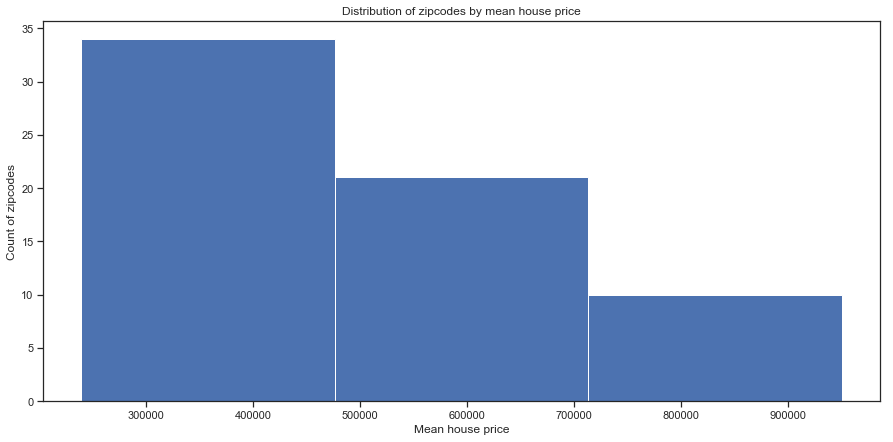

In [68]:
#choose how many zipcode categories to create by selecting n number of bins for a histogram
n = 3
a, b, c, d = zipcodebins(mean_prices_olo, n)

In [69]:
bin_dividors = []
for i in b:
    bin_dividors.append(round(i, 0))
    
bin_dividors

[239072.0, 476254.0, 713437.0, 950620.0]

In [70]:
#manually create n number of variables 
##(last number should be n -1)

slice_a = int(c[0])
slice_b = (int(c[0] + int(c[1])))
slice_c = int(c[2])

zip_category_a = d[:slice_a]
zip_category_b = d[slice_a:slice_b]
zip_category_c = d[slice_b:(slice_b + slice_c)]

# Create a zipcode category column in df_trim:

In [71]:
#A dictionary with zipcodes as the key values is required for each bin

list_a = list(zip_category_a.zipcode)
dict_a = dict(enumerate(list_a))
res_a = dict((v,k) for k,v in dict_a.items())

list_b = list(zip_category_b.zipcode)
dict_b = dict(enumerate(list_b))
res_b = dict((v,k) for k,v in dict_b.items())

list_c = list(zip_category_c.zipcode)
dict_c = dict(enumerate(list_c))
res_c = dict((v,k) for k,v in dict_c.items())

In [72]:
#A new list will be created that will be a column for zipcode bins.

zipcode_bin_list = []

for i in df_trim.zipcode:
    if res_a.get(i)!=None:
        zipcode_bin_list.append('A')
    elif res_b.get(i)!=None:
        zipcode_bin_list.append('B')
    elif res_c.get(i)!=None:
        zipcode_bin_list.append('C')
    else:
        #These zipcodes were the outliers removed when creating the zipcode bins
        zipcode_bin_list.append('OL')

zipcode_bin_col = {'zipcode_bins': zipcode_bin_list}

zip_df = pd.DataFrame(zipcode_bin_col)

In [73]:
zip_df.zipcode_bins.value_counts()

A     8478
B     6809
C     2317
OL     495
Name: zipcode_bins, dtype: int64

In [74]:
cod(zip_df)

This dataset contains 18099 entries and 1 columns


## Create dummy variables for zipcode_bins

In [75]:
zipcode_dummies = pd.get_dummies(zip_df["zipcode_bins"], prefix = 'zip_bin', drop_first = True)

In [76]:
zipcode_dummies.head()

,zip_bin_B,zip_bin_C,zip_bin_OL
0,0,0,0
1,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0


# df_dumm is a new dataframe that will include dummy variables:

In [77]:
df_dumm = pd.concat([df_trim, zip_df, zipcode_dummies], axis=1)

In [78]:
df_dumm.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement_size,zipcode_bins,zip_bin_B,zip_bin_C,zip_bin_OL
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,98178,47.5112,-122.257,0,A,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,98125,47.7210,-122.319,400,A,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,98028,47.7379,-122.233,0,A,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,98136,47.5208,-122.393,910,B,1,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,98074,47.6168,-122.045,0,B,1,0,0


In [79]:
#df_dumm = pd.concat([df_trim, zipcode_dummies], axis=1)

In [80]:
cod(df_dumm)

This dataset contains 18099 entries and 20 columns


In [81]:
df_dumm.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement_size,zipcode_bins,zip_bin_B,zip_bin_C,zip_bin_OL
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,98178,47.5112,-122.257,0,A,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,98125,47.7210,-122.319,400,A,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,98028,47.7379,-122.233,0,A,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,98136,47.5208,-122.393,910,B,1,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,98074,47.6168,-122.045,0,B,1,0,0


## Create Grade Bins

In [82]:
df_dumm['grade_bins'] = np.where((df_dumm['grade'] == 6) | (df_dumm['grade'] == 7), 'A', df_dumm['grade'])

In [83]:
df_dumm['grade_bins'] = np.where((df_dumm['grade'] == 8) | (df_dumm['grade'] ==9), 'B', df_dumm['grade_bins'])

In [84]:
df_dumm['grade_bins'] = np.where((df_dumm['grade'] == 10) | (df_dumm['grade'] ==11), 'C', df_dumm['grade_bins'])

In [85]:
grade_dummies = pd.get_dummies(df_dumm["grade_bins"], prefix = 'grade_bin', drop_first = True)

In [86]:
df_dumm = pd.concat([df_dumm, grade_dummies], axis=1)

In [87]:
#df_dumm.drop('grade_bins', axis=1, inplace=True)

In [88]:
df_dumm.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,...,lat,long,basement_size,zipcode_bins,zip_bin_B,zip_bin_C,zip_bin_OL,grade_bins,grade_bin_B,grade_bin_C
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,...,47.5112,-122.257,0,A,0,0,0,A,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,...,47.7210,-122.319,400,A,0,0,0,A,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,...,47.7379,-122.233,0,A,0,0,0,A,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,...,47.5208,-122.393,910,B,1,0,0,A,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,...,47.6168,-122.045,0,B,1,0,0,B,1,0


In [89]:
df_dumm.grade_bins.value_counts()

A    9751
B    7392
C     956
Name: grade_bins, dtype: int64

## Create categorical variable for basement yes / no

In [90]:
df_dumm['basement_status'] = np.where((df_dumm['basement_size'] == 0), 'no', 'yes')

In [91]:
df_dumm.basement_status.value_counts()

no     10802
yes     7297
Name: basement_status, dtype: int64

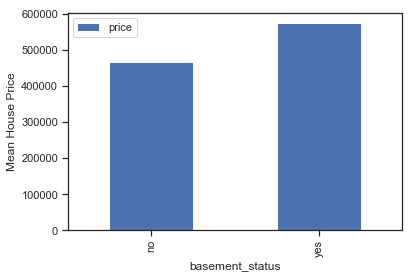

In [92]:
ax = df_dumm.groupby(['basement_status']).mean()[['price']].plot(kind='bar');
ax.set_ylabel('Mean House Price');

In [93]:
bsmt_dummies = pd.get_dummies(df_dumm["basement_status"], prefix = 'has_basement', drop_first = True)

In [94]:
df_dumm = pd.concat([df_dumm, bsmt_dummies], axis=1)

In [95]:
df_dumm.drop('basement_status', axis=1, inplace=True)

In [96]:
cod(df_dumm)
df_dumm.tail()

This dataset contains 18099 entries and 24 columns


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,...,long,basement_size,zipcode_bins,zip_bin_B,zip_bin_C,zip_bin_OL,grade_bins,grade_bin_B,grade_bin_C,has_basement_yes
18094,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,3,8,...,-122.346,0,B,1,0,0,B,1,0,0
18095,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,3,8,...,-122.362,0,A,0,0,0,B,1,0,0
18096,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,3,7,...,-122.299,0,B,1,0,0,A,0,0,0
18097,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,3,8,...,-122.069,0,B,1,0,0,B,1,0,0
18098,1523300157,10/15/2014,325000.0,2,0.75,1020,1076,2.0,3,7,...,-122.299,0,B,1,0,0,A,0,0,0


# Create dummy variables for floors:

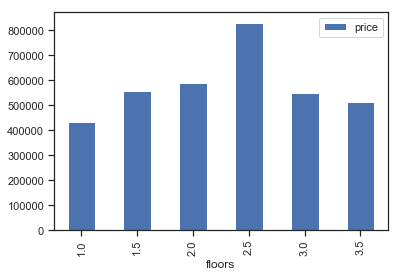

In [97]:
df_dumm.groupby(['floors']).mean()[['price']].plot(kind='bar');

In [98]:
#df_dumm['floors'] = df_dumm['floors'].astype('category')

In [99]:
floors_dummies = pd.get_dummies(df_dumm["floors"], prefix = 'floors', drop_first = True)

In [100]:
df_dumm = pd.concat([df_dumm, floors_dummies], axis=1)

In [101]:
#the float values in the floors dummies column names can be problematic
df_dumm.rename(inplace=True, columns={
                                "floors_1.5": "floors1_5",
                                "floors_2.0": "floors2",
                                "floors_2.5": "floors2_5",
                                "floors_3.0": "floors3",
                                "floors_3.5": "floors3_5"
                               })

In [102]:
#df_dumm.drop('floors', axis= 1, inplace=True)

In [103]:
df_dumm.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,...,zip_bin_OL,grade_bins,grade_bin_B,grade_bin_C,has_basement_yes,floors1_5,floors2,floors2_5,floors3,floors3_5
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,...,0,A,0,0,0,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,...,0,A,0,0,1,0,1,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,...,0,A,0,0,0,0,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,...,0,A,0,0,1,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,...,0,B,1,0,0,0,0,0,0,0


In [104]:
df_dumm.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'yr_built',
       'zipcode', 'lat', 'long', 'basement_size', 'zipcode_bins', 'zip_bin_B',
       'zip_bin_C', 'zip_bin_OL', 'grade_bins', 'grade_bin_B', 'grade_bin_C',
       'has_basement_yes', 'floors1_5', 'floors2', 'floors2_5', 'floors3',
       'floors3_5'],
      dtype='object')

In [105]:
len(df_dumm[(df_dumm['grade_bin_C'] == 0) & (df_dumm['grade_bin_B'] == 1)])

7392

In [106]:
df_dumm.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,...,zip_bin_OL,grade_bins,grade_bin_B,grade_bin_C,has_basement_yes,floors1_5,floors2,floors2_5,floors3,floors3_5
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,...,0,A,0,0,0,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,...,0,A,0,0,1,0,1,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,...,0,A,0,0,0,0,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,...,0,A,0,0,1,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,...,0,B,1,0,0,0,0,0,0,0


# Model 2:

In [107]:
model_2 = df_dumm[['price', 'bedrooms', 'sqft_living', 'zip_bin_B', 'zip_bin_C', 'zip_bin_OL',
       'grade_bin_B', 'grade_bin_C', 'has_basement_yes', 'floors1_5',
       'floors2', 'floors2_5', 'floors3', 'floors3_5']]
#.iloc[:,:3]

In [108]:
y_2 = model_2[['price']]
X_2 = model_2.drop(['price'], axis = 1)

In [109]:
model_no = 'Model 2'

X = X_2
y = y_2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)

linreg.fit(X_train,y_train)
yhat_train = linreg.predict(X_train)
yhat_test = linreg.predict(X_test)
mse_train = np.sum((y_train-yhat_train)**2)/len(y_train)
rmse_train = np.sqrt(mse_train)
mse_test =np.sum((y_test-yhat_test)**2)/len(y_test)
rmse_test = np.sqrt(mse_test)
y_int = sm.add_constant(X)
model = sm.OLS(y,y_int).fit()

print('-------\n' + model_no + '\n-------')
print('The train mse is ' + str(list(mse_train)[0]))
print('The test mse is  ' + str(list(mse_test)[0]))
print('\nThe train rmse is ' + str(list(rmse_train)[0]))
print('The test rmse is ' + str(list(rmse_test)[0]))

#list((mse_train/mse_test)*100)[0]

print('\nThe R-Squared is ' + str(model.rsquared))
model.summary()

-------
Model 2
-------
The train mse is 19276098125.32847
The test mse is  19411459018.351704

The train rmse is 138838.38851459083
The test rmse is 139325.01217782722

The R-Squared is 0.7360577533599861


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     3880.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        08:03:19   Log-Likelihood:            -2.4000e+05
No. Observations:               18099   AIC:                         4.800e+05
Df Residuals:                   18085   BIC:                         4.801e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.039e+05   4336.135     23.964      0.000    9.54e+04    1.12e+05
bedrooms         -2.133e+04   1559.166    -13.677      0.000   -2.44e+04   -1.83e+04
sqft_living        153.2962      2.304     66.527      0.000     148.780     157.813
zip_bin_B         1.765e+05   2347.812     75.183      0.000    1.72e+05    1.81e+05
zip_bin_C          3.11e+05   3445.708     90.259      0.000    3.04e+05    3.18e+05
zip_bin_OL        5.669e+05   6612.515     85.734      0.000    5.54e+05     5.8e+05
grade_bin_B       5.476e+04   2738.501     19.995      0.000    4.94e+04    6.01e+04
grade_bin_C       2.216e+05   6226.450     35.583      0.000    2.09e+05    2.34e+05
has_basement_yes   2.84e+04   2389.974     11.883      0.000    2.37e+04    3.31e+04
floors1_5         7.462e+04   3885.487     19.206      0.000     6.7e+04    8.22e+04
floors2          -9599.6137   2811.901     -3.414      0.001   -1.51e+04   -4088.021
floors2_5         9.281e+04   1.27e+04      7.294      0.000    6.79e+04    1.18e+05
floors3           2.136e+04   6230.155      3.428      0.001    9147.369    3.36e+04
floors3_5         1205.8649   5.68e+04      0.021      0.983    -1.1e+05    1.13e+05
==============================================================================
Omnibus:                     5567.049   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32597.099
Skew:                           1.353   Prob(JB):                         0.00
Kurtosis:                       8.992   Cond. No.                     1.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The MSE of Model 2 is significantly lower than before, and R-squared is over 70%

## Do the residuals of the model follow a normal distribution?

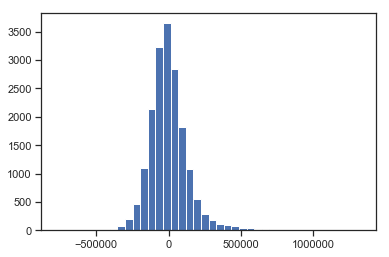

In [110]:
plt.hist(list(model.resid), bins=40);

## Normalise continuous variables (not target) before feature selection:

In [111]:
model_2.columns[:3]

Index(['price', 'bedrooms', 'sqft_living'], dtype='object')

In [112]:
model_2_norm = model_2.copy()
for col in model_2_norm.columns[:3]:
    if col != 'price':
        model_2_norm[col] = (model_2_norm[col] - model_2_norm[col].mean()) / model_2_norm[col].std()

In [113]:
model_2_norm.head()

,price,bedrooms,sqft_living,zip_bin_B,zip_bin_C,zip_bin_OL,grade_bin_B,grade_bin_C,has_basement_yes,floors1_5,floors2,floors2_5,floors3,floors3_5
0,221900.0,-0.409788,-1.031045,0,0,0,0,0,0,0,0,0,0,0
1,538000.0,-0.409788,0.726714,0,0,0,0,0,1,0,1,0,0,0
2,180000.0,-1.559314,-1.549520,0,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.739739,-0.044677,1,0,0,0,0,1,0,0,0,0,0
4,510000.0,-0.409788,-0.398758,1,0,0,1,0,0,0,0,0,0,0


In [114]:
y_2_norm = model_2_norm[['price']]
X_2_norm = model_2_norm.drop(['price'], axis = 1)

In [115]:
X = X_2_norm
y = y_2_norm

# Feature Selection with RFE

In [116]:
r_list = []
adj_r_list = []

for n in [5,6,7]: #list of n best features to select
    select_n = RFE(linreg, n_features_to_select = n)
    select_n = select_n.fit(X, np.ravel(y))
    selected_columns = X.columns[select_n.support_ ]
    print(selected_columns)
    linreg.fit(X[selected_columns],y)
    yhat = linreg.predict(X[selected_columns])
    SS_Residual = np.sum((y-yhat)**2)
    SS_Total = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    print(r_squared)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    print(adjusted_r_squared)
r_list.append(r_squared)
adj_r_list.append(adjusted_r_squared)


Index(['sqft_living', 'zip_bin_B', 'zip_bin_C', 'zip_bin_OL', 'grade_bin_C'], dtype='object')
price    0.71886
dtype: float64
price    0.718658
dtype: float64
Index(['sqft_living', 'zip_bin_B', 'zip_bin_C', 'zip_bin_OL', 'grade_bin_C',
       'floors2_5'],
      dtype='object')
price    0.719722
dtype: float64
price    0.71952
dtype: float64
Index(['sqft_living', 'zip_bin_B', 'zip_bin_C', 'zip_bin_OL', 'grade_bin_C',
       'floors1_5', 'floors2_5'],
      dtype='object')
price    0.723782
dtype: float64
price    0.723583
dtype: float64


# Step-wise selection with p-values  (1-11-12 4/6)

In [117]:
import statsmodels.api as sm

In [118]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [119]:
result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

Add  sqft_living                    with p-value 0.0
Add  zip_bin_C                      with p-value 0.0
Add  zip_bin_B                      with p-value 0.0
Add  zip_bin_OL                     with p-value 0.0
Add  grade_bin_C                    with p-value 5.12858e-192
Add  grade_bin_B                    with p-value 5.4448e-73
Add  floors1_5                      with p-value 2.61662e-77
Add  has_basement_yes               with p-value 4.97162e-44
Add  bedrooms                       with p-value 8.6495e-42
Add  floors2_5                      with p-value 7.46599e-15
Add  floors3                        with p-value 8.88528e-06
Add  floors2                        with p-value 0.000636069
resulting features:
['sqft_living', 'zip_bin_C', 'zip_bin_B', 'zip_bin_OL', 'grade_bin_C', 'grade_bin_B', 'floors1_5', 'has_basement_yes', 'bedrooms', 'floors2_5', 'floors3', 'floors2']


# Final Model:

In [120]:
kcd_final = df_dumm[['price','sqft_living', 'zip_bin_B', 'zip_bin_C', 'zip_bin_OL', 'grade_bin_B', 'grade_bin_C']]
kcd_final.head()

,price,sqft_living,zip_bin_B,zip_bin_C,zip_bin_OL,grade_bin_B,grade_bin_C
0,221900.0,1180,0,0,0,0,0
1,538000.0,2570,0,0,0,0,0
2,180000.0,770,0,0,0,0,0
3,604000.0,1960,1,0,0,0,0
4,510000.0,1680,1,0,0,1,0


# k-fold cross-validation

In [121]:
y_final = kcd_final[['price']]
X_final = kcd_final.drop(['price'], axis = 1)

In [122]:
def kfolds(data, k):
    #Force data as pandas dataframe
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
            
    return folds 

In [123]:
X = X_final
y = y_final

kcd_k_fold_data = pd.concat([X.reset_index(drop=True), y], axis=1)

k=10

kcd_k_folds = kfolds(kcd_k_fold_data, k)

test_errs = []
train_errs = []

for n in range(k):
    # Split in train and test for the fold
    train = pd.concat([fold for i, fold in enumerate(kcd_k_folds) if i!=n])
    test = kcd_k_folds[n]
    # Fit a linear regression model
    linreg.fit(train[X.columns], train[y.columns])
    #Evaluate Train and Test Errors
    y_hat_train = linreg.predict(train[X.columns])
    y_hat_test = linreg.predict(test[X.columns])
    train_residuals = y_hat_train - train[y.columns]
    test_residuals = y_hat_test - test[y.columns]
    train_errs.append(np.mean(train_residuals.astype(float)**2))
    test_errs.append(np.mean(test_residuals.astype(float)**2))
#print(train_errs)
#print(test_errs)

output_train_errs = pd.DataFrame(train_errs).rename(columns={'price': 'MSE: train'})
output_test_errs = pd.DataFrame(test_errs).rename(columns={'price': 'MSE: test'})
train_test_errs = pd.concat([output_train_errs, output_test_errs], axis = 1)
avg_test_err = sum(test_errs)/k
avg_train_err = sum(train_errs)/k

print('The average test MSE is ' + str(list(avg_test_err)[0]))
print('The average train MSE is ' + str(list(avg_train_err)[0]))
print('The avg test MSE as a percentage of avg train MSE is ' + str(list(((avg_test_err/avg_train_err)*100))[0]))
train_test_errs

The average test MSE is 20249082440.7239
The average train MSE is 20184989495.05013
The avg test MSE as a percentage of avg train MSE is 100.31752776333865


,MSE: train,MSE: test
0,2.041962e+10,1.813962e+10
1,1.997116e+10,2.216363e+10
2,2.026160e+10,1.954324e+10
3,2.033592e+10,1.886965e+10
4,2.022343e+10,1.988326e+10
5,2.000466e+10,2.185582e+10
6,2.008355e+10,2.116825e+10
7,1.990209e+10,2.276450e+10
8,2.034042e+10,1.882895e+10
9,2.030743e+10,1.927391e+10


# Run StatsModels on the final model

In [124]:
model_no = 'Final Model'

X = X_final
y = y_final

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)

linreg.fit(X_train,y_train)
yhat_train = linreg.predict(X_train)
yhat_test = linreg.predict(X_test)
mse_train = np.sum((y_train-yhat_train)**2)/len(y_train)
rmse_train = np.sqrt(mse_train)
mse_test =np.sum((y_test-yhat_test)**2)/len(y_test)
rmse_test = np.sqrt(mse_test)
y_int = sm.add_constant(X)
model = sm.OLS(y,y_int).fit()

print('-------\n' + model_no + '\n-------')
print('The train mse is ' + str(list(mse_train)[0]))
print('The test mse is  ' + str(list(mse_test)[0]))
print('\nThe train rmse is ' + str(list(rmse_train)[0]))
print('The test rmse is ' + str(list(rmse_test)[0]))

#list((mse_train/mse_test)*100)[0]

print('\nThe R-Squared is ' + str(model.rsquared))
model.summary()

-------
Final Model
-------
The train mse is 20194892193.4349
The test mse is  20177186749.6311

The train rmse is 142108.73369865378
The test rmse is 142046.42462811622

The R-Squared is 0.7238885771309159


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     7905.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        08:03:25   Log-Likelihood:            -2.4041e+05
No. Observations:               18099   AIC:                         4.808e+05
Df Residuals:                   18092   BIC:                         4.809e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7.193e+04   3265.782     22.027      0.000    6.55e+04    7.83e+04
sqft_living   140.0707      1.766     79.321      0.000     136.609     143.532
zip_bin_B    1.866e+05   2358.698     79.118      0.000    1.82e+05    1.91e+05
zip_bin_C    3.262e+05   3475.751     93.848      0.000    3.19e+05    3.33e+05
zip_bin_OL   5.728e+05   6729.060     85.121      0.000     5.6e+05    5.86e+05
grade_bin_B  4.727e+04   2604.087     18.153      0.000    4.22e+04    5.24e+04
grade_bin_C   2.13e+05   6060.340     35.144      0.000    2.01e+05    2.25e+05
==============================================================================
Omnibus:                     5670.469   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31474.606
Skew:                           1.399   Prob(JB):                         0.00
Kurtosis:                       8.823   Cond. No.                     1.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Residuals

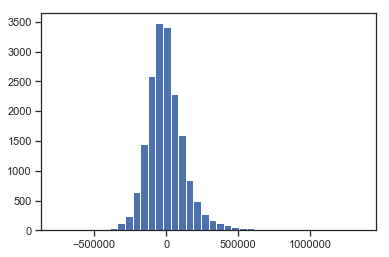

In [125]:
plt.hist(list(model.resid), bins=40);

### Final model summary
The final model uses grade categories, zipcode categories and sqft_living to predict house prices with an accuracy of over 70% (according the R-Squared value of the model).  All of these features have p-values either equal to or almost equal to 0. The features were chosen based on RFE / Step-wise selection findings as well as an intuitive sense of what would be useful as real-world tool to predict house-prices (that would make sense to non-technical stakeholders).

The model is based on a dataset that has been trimmed to represent a more typical range of houses - so it cannot be be used to predict houses that fall outside of that range (for example, prices above $2million).  In addition it is worth noting that this dataset of around 20k houses is only about 2.5 percent of the total number of housing units in King County, so there is no guarantee as to the reliability of this particular sample.

Nevertheless the model provides a useful and relatively robust starting point for predicting house prices in King County.

### Explanation of coefficients
sqft_living: 140.0707. <br> 
This is the only continuous variable used in the model.  For each additional square-foot added to the living space of a property, its price will go up by $140.

zip_bin_B: 186616.408222 <br>
This is a coefficient derived from creating zipcode categories based on the mean house prices in each zipcode.  It is assumed that if a house is not in zip_bin_B, C or OL (outliers), then it is in zip_bin_A - and the associated value of house prices in that zip_bin is incorporated into the intercept value of 71934.196.  If a house does belong to a zip code in zip_bin_B, however, then its price will increase by $186616.

grade_bin_C: 212985.2102 <br>
Similar to the zip_bins, the grade bins provide coefficients based on creating three grade categories.  It is assumed that if a house is not in grade_bin_B or C, then it is in grade_bin_A - and the associated value of house prices in that grade_bin is again incorporated into the intercept value.  For houses in grade_bin_C, the price will be $212985 higher.  It is worth noting that although grade_bin_C has the highest coefficient of the grade categories, it is still lower than the two highest zipcode categories.

# Get the coefficients for the final model and make predictions:

In [126]:
linreg.fit(X,y);

In [127]:
data = {'Coefficients': list(linreg.coef_[0])}

prediction_df = pd.DataFrame.from_dict(data, orient='index', columns=list(X.columns))
prediction_df

,sqft_living,zip_bin_B,zip_bin_C,zip_bin_OL,grade_bin_B,grade_bin_C
Coefficients,140.070659,186616.408222,326191.0546,572782.770165,47270.872986,212985.210242


In [128]:
print('The intercept is ' + str(list(linreg.intercept_)[0]))

The intercept is 71934.19633409119


In [129]:
def price_prediction_func(any_df, df_idx):
    zip_bin_B = 0
    zip_bin_C = 0
    zip_bin_OL = 0
    grade_bin_B = 0
    grade_bin_C = 0
    if list(any_df[df_idx:df_idx+1]['zip_bin_B'])[0] == 1:
        zip_bin_B = 1
    elif list(any_df[df_idx:df_idx+1]['zip_bin_C'])[0] == 1:
        zip_bin_C = 1
    elif list(any_df[df_idx:df_idx+1]['zip_bin_OL'])[0] == 1:
        zip_bin_OL = 1

    if (zip_bin_B == 0) & (zip_bin_C == 0) & (zip_bin_OL == 0):
        zip_cat = 'A'
    elif (zip_bin_B == 1) & (zip_bin_C == 0) & (zip_bin_OL == 0):
        zip_cat = 'B'
    elif (zip_bin_B == 0) & (zip_bin_C == 1) & (zip_bin_OL == 0):
        zip_cat = 'C'
    elif (zip_bin_B == 0) & (zip_bin_C == 0) & (zip_bin_OL == 1):
        zip_cat = 'D'
    
    if list(any_df[df_idx:df_idx+1]['grade_bin_B'])[0] == 1:
        grade_cat = 'B'
    elif list(any_df[df_idx:df_idx+1]['grade_bin_C'])[0] == 1:
        grade_cat = 'C'
    else:
        grade_cat = 'A'
    
    index = list(any_df[df_idx:df_idx+1]['index'])[0]
    sqft = list(any_df[df_idx:df_idx+1]['sqft_living'])[0]
    sale_price = (int(list(any_df[df_idx:df_idx+1]['price'])[0]))
    kc_id = list(any_df[df_idx:df_idx+1]['id'])[0]
    
    
#    if zip_cat == 'A':
    results = []
    grade_A_result = ((sqft*prediction_df.sqft_living[0]) + 
                          (zip_bin_B*prediction_df.zip_bin_B[0]) + 
                          (zip_bin_C*prediction_df.zip_bin_C[0]) + 
                          (zip_bin_OL*prediction_df.zip_bin_OL[0]) + 
                          (grade_bin_B*prediction_df.grade_bin_B[0]) +
                          (grade_bin_C*prediction_df.grade_bin_C[0]) +                    
                          list(linreg.intercept_)[0])
    results.append(int(round(grade_A_result,0)))
    grade_bin_B = 1
    grade_B_result = ((sqft*prediction_df.sqft_living[0]) + 
                          (zip_bin_B*prediction_df.zip_bin_B[0]) + 
                          (zip_bin_C*prediction_df.zip_bin_C[0]) + 
                          (zip_bin_OL*prediction_df.zip_bin_OL[0]) + 
                          (grade_bin_B*prediction_df.grade_bin_B[0]) +
                          (grade_bin_C*prediction_df.grade_bin_C[0]) +                    
                          list(linreg.intercept_)[0])
    results.append(int(round(grade_B_result)))
    grade_bin_B = 0
    grade_bin_C = 1
    grade_C_result = ((sqft*prediction_df.sqft_living[0]) + 
                          (zip_bin_B*prediction_df.zip_bin_B[0]) + 
                          (zip_bin_C*prediction_df.zip_bin_C[0]) + 
                          (zip_bin_OL*prediction_df.zip_bin_OL[0]) + 
                          (grade_bin_B*prediction_df.grade_bin_B[0]) +
                          (grade_bin_C*prediction_df.grade_bin_C[0]) +                    
                          list(linreg.intercept_)[0])
    results.append(int(round(grade_C_result, 0)))
    
    cols = ['index', 'id', 'sqft_living', 'sale_price', 'zip_cat', 'grade_cat', 'pred_price_grade_A', 'pred_price_grade_B', 'pred_price_grade_C']
    results = [[index, kc_id, sqft, sale_price, zip_cat, grade_cat, results[0], results[1], results[2]]]
    output = pd.DataFrame(results, columns = cols)
    return output

In [130]:
def dataframe_predict(df_to_predict):
    to_concat = []
    for i in list(range(len(df_to_predict))):
        to_concat.append(price_prediction_func(df_to_predict, i))
    output = pd.concat(to_concat)
    output.reset_index(inplace=True, drop=True)
    return output

In [131]:
df_pred_frac = df_dumm.sample(frac=0.0007, random_state=1345)
df_pred_frac.reset_index(inplace=True)

In [132]:
dataframe_predict(df_pred_frac)

,index,id,sqft_living,sale_price,zip_cat,grade_cat,pred_price_grade_A,pred_price_grade_B,pred_price_grade_C
0,16317,9492500140,3010,839950,C,B,819738,867009,1032723
1,7896,7970800100,1982,283200,A,B,349554,396825,562539
2,12806,1087900050,2000,560000,C,A,678267,725537,891252
3,15031,3332000061,2020,552500,A,A,354877,402148,567862
4,6734,3971700937,1260,270000,A,A,248423,295694,461408
5,442,7800800160,2120,375000,A,B,368884,416155,581869
6,13477,9346900170,2330,615000,C,B,724490,771761,937475
7,2164,179003055,1200,210000,A,A,240019,287290,453004
8,8618,9346920260,2500,646000,C,B,748302,795573,961287
9,16454,5126300060,2610,515000,B,B,624135,671406,837120


# APPENDIX

## How do the features look when grade is the target?

In [133]:
df_view_grade = df.drop(['id', 'date', 'zipcode', 'lat', 'long'], axis=1)

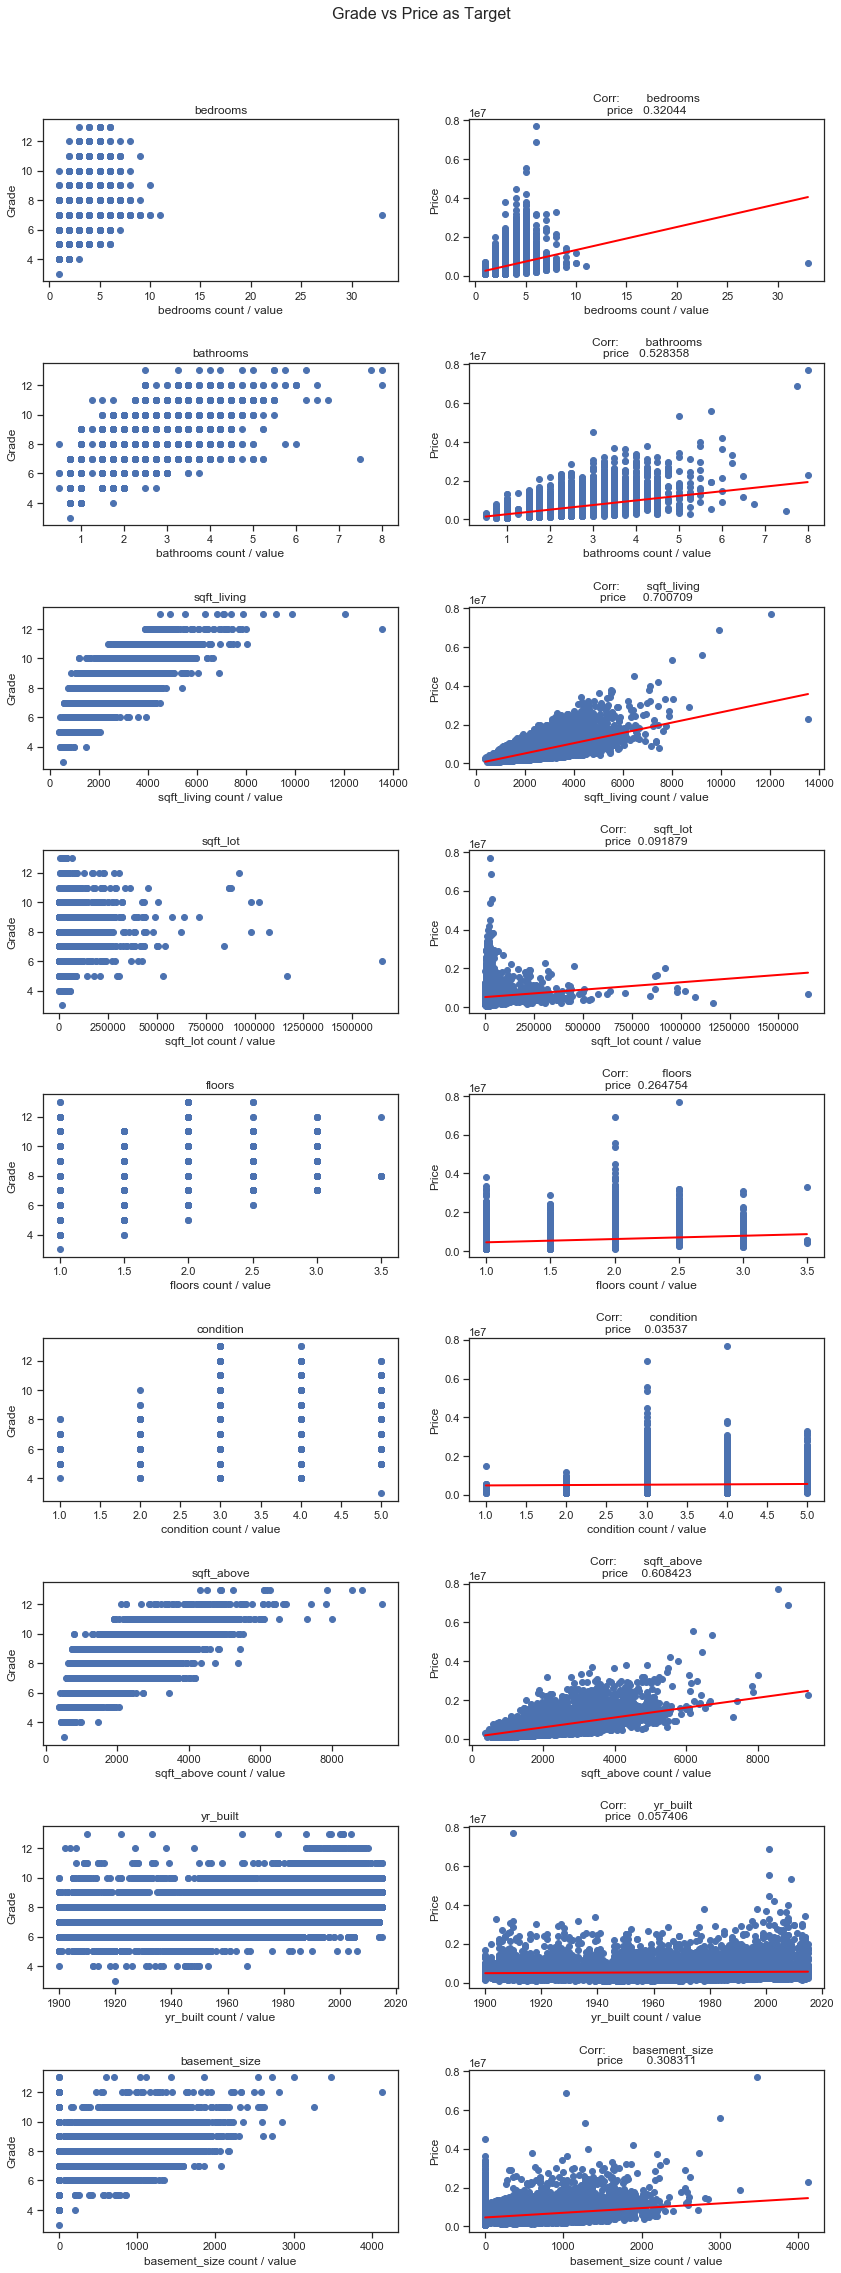

In [134]:
#%%capture
fig = plt.figure(figsize = (14,52))
fig.suptitle('Grade vs Price as Target', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plot_pos = 1

for i in df_view_grade.columns:
    if (i != 'grade') & (i != 'price'):
        ax = plt.subplot(13,2,plot_pos)
        ax.scatter(df[[i]], df.grade)
        ax.set_xlabel(str(i) + ' count / value')
        ax.set_ylabel('Grade')
        #lm = smf.ols(formula = 'grade ~ ' + str(i), data = df).fit()
        #X_new = pd.DataFrame({str(i): [df[i].min(), df[i].max()]})
        #preds = lm.predict(X_new)
        #ax.plot(X_new, preds, c='red', linewidth=2)
        #ax.set_title('Corr: ' + str(df[['grade',i]].corr().iloc[0:1,1:]))
        ax.set_title(str(i))
        plt.subplots_adjust(hspace=0.5)
        plot_pos += 1
        ax = plt.subplot(13,2,plot_pos)
        ax.scatter(df[[i]], df.price)
        ax.set_xlabel(str(i) + ' count / value')
        ax.set_ylabel('Price')
        lm = smf.ols(formula = 'price ~ ' + str(i), data = df).fit()
        X_new = pd.DataFrame({str(i): [df[i].min(), df[i].max()]})
        preds = lm.predict(X_new)
        ax.plot(X_new, preds, c='red', linewidth=2)
        ax.set_title('Corr: ' + str(df[['price',i]].corr().iloc[0:1,1:]))
        plt.subplots_adjust(hspace=0.5)
        plot_pos += 1
        
#fig.savefig('Grade vs Price as target')